# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [138]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

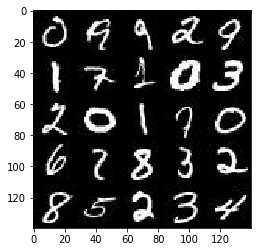

In [139]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

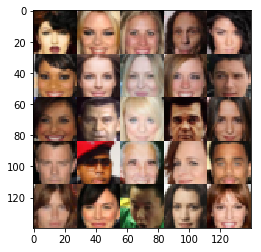

In [140]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [141]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [142]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [143]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 or 28x28x3
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(mean=0, stddev=0.02))
        relu1 = tf.maximum(0.1 * x1, x1)
        # 14x14x32
    
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=1, padding='same', kernel_initializer = tf.random_normal_initializer(mean=0, stddev=0.02))
        x2 = tf.layers.dropout(x2, rate=0.2)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.1 * bn2, bn2)
        # 14x14x64
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(mean=0, stddev=0.02))
        x3 = tf.layers.dropout(x3, rate=0.2)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.1 * bn3, bn3)
        # 7x7x128

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [144]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(0.1 * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(mean=0, stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.1 * x2, x2)
        # 14x14x64 now
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(mean=0, stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.1 * x3, x3)
        # 28x28x32 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer = tf.random_normal_initializer(mean=0, stddev=0.02))
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [145]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [146]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [147]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [148]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learning_rate2 = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
      
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate2, beta1)
    

    losses = []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
          
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))


                
                # Run optimizers
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate2: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate2: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate2: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    
                    _ = show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7040... Generator Loss: 0.7140
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 1.1887
Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 0.4074
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 1.4771
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 1.0548
Epoch 1/2... Discriminator Loss: 1.4161... Generator Loss: 0.3831
Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 0.7706
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.7232
Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 0.6671
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 0.6516


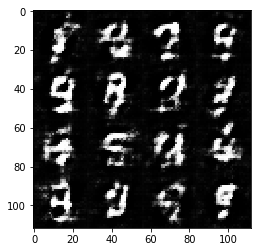

Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 0.5011
Epoch 1/2... Discriminator Loss: 1.2068... Generator Loss: 0.7824
Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 1.1268
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.5000
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 0.6508
Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 0.6634
Epoch 1/2... Discriminator Loss: 1.1790... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 0.9279
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 0.5341


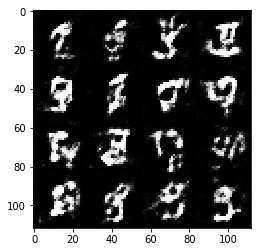

Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 0.9584
Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 0.8449
Epoch 1/2... Discriminator Loss: 1.0956... Generator Loss: 0.9060
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 1.1498
Epoch 1/2... Discriminator Loss: 1.1765... Generator Loss: 0.6082
Epoch 1/2... Discriminator Loss: 1.2225... Generator Loss: 0.8739
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 0.7292
Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 0.5330
Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 0.7935


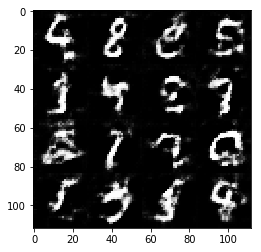

Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 0.7866
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 0.7699
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 0.9392
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.5849
Epoch 1/2... Discriminator Loss: 1.2267... Generator Loss: 0.6238
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 1.2679
Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 0.6525
Epoch 1/2... Discriminator Loss: 1.1736... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 1.2471... Generator Loss: 0.8197
Epoch 1/2... Discriminator Loss: 1.1929... Generator Loss: 0.8914


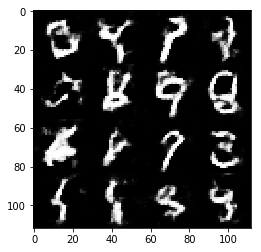

Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 0.6504
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 1.2274... Generator Loss: 1.0337
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.4874
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 1.0338
Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 0.6795
Epoch 1/2... Discriminator Loss: 1.2455... Generator Loss: 0.8255
Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 0.4875
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.5867
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 0.6014


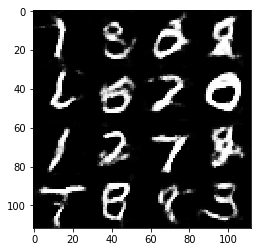

Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.8577
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 0.9758
Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 0.8032
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.7425
Epoch 1/2... Discriminator Loss: 1.2661... Generator Loss: 0.9820
Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 1.2289... Generator Loss: 0.7080
Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 0.7544
Epoch 1/2... Discriminator Loss: 1.2933... Generator Loss: 0.7390
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 0.5612


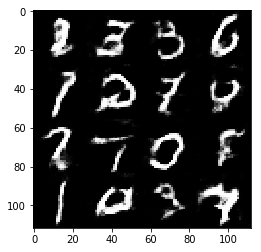

Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.5091
Epoch 1/2... Discriminator Loss: 1.2114... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.6860
Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 0.4128
Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 0.9335
Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 0.7722
Epoch 1/2... Discriminator Loss: 1.2810... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 1.1998... Generator Loss: 0.7308
Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 0.5946


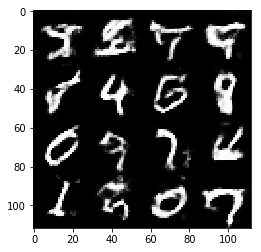

Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 0.7055
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 0.7546
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.7278
Epoch 1/2... Discriminator Loss: 1.2221... Generator Loss: 0.9159
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 0.7997
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 1.0706
Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.3186... Generator Loss: 0.4685
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 0.8298
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 0.5342


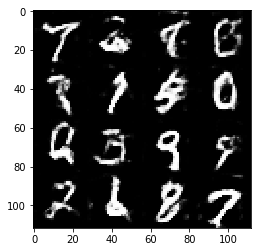

Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.7385
Epoch 1/2... Discriminator Loss: 1.1873... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 1.1841... Generator Loss: 0.8992
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 0.5714
Epoch 1/2... Discriminator Loss: 1.2174... Generator Loss: 0.6044
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 1.2887... Generator Loss: 0.6181
Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 0.5921
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.4021
Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 0.7226


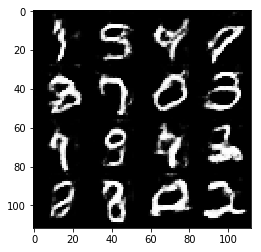

Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 0.6583
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.8358
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 0.9163
Epoch 2/2... Discriminator Loss: 1.1808... Generator Loss: 0.6494
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.7215
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.9192
Epoch 2/2... Discriminator Loss: 1.2007... Generator Loss: 0.9457
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 0.8355
Epoch 2/2... Discriminator Loss: 1.1676... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 0.5985


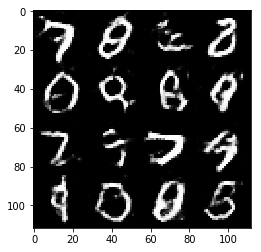

Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.8920
Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 0.7669
Epoch 2/2... Discriminator Loss: 1.2340... Generator Loss: 0.8069
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.6623
Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 1.2897... Generator Loss: 0.5333
Epoch 2/2... Discriminator Loss: 1.2849... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 1.2645... Generator Loss: 0.7496


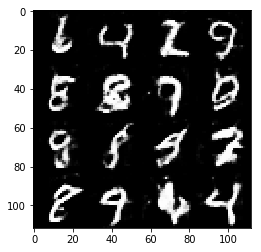

Epoch 2/2... Discriminator Loss: 1.1641... Generator Loss: 0.7675
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 0.9069
Epoch 2/2... Discriminator Loss: 1.2678... Generator Loss: 0.7019
Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 0.7022
Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 0.5607
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 0.7589
Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 0.9911
Epoch 2/2... Discriminator Loss: 1.3409... Generator Loss: 0.4665
Epoch 2/2... Discriminator Loss: 1.2504... Generator Loss: 0.6527
Epoch 2/2... Discriminator Loss: 1.1772... Generator Loss: 0.7595


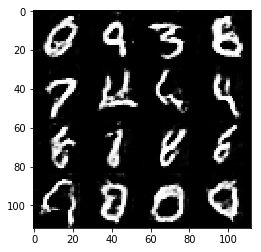

Epoch 2/2... Discriminator Loss: 1.1801... Generator Loss: 0.8750
Epoch 2/2... Discriminator Loss: 1.1999... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.8325
Epoch 2/2... Discriminator Loss: 1.1978... Generator Loss: 0.6569
Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 0.6827
Epoch 2/2... Discriminator Loss: 1.1729... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.9321
Epoch 2/2... Discriminator Loss: 1.2656... Generator Loss: 0.6017
Epoch 2/2... Discriminator Loss: 1.1874... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 0.5955


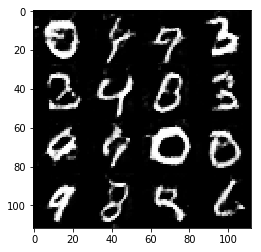

Epoch 2/2... Discriminator Loss: 1.1938... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 0.6493
Epoch 2/2... Discriminator Loss: 1.2723... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.5991
Epoch 2/2... Discriminator Loss: 1.2384... Generator Loss: 0.7302
Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 1.2269... Generator Loss: 0.8663
Epoch 2/2... Discriminator Loss: 1.1602... Generator Loss: 0.7510
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.6231
Epoch 2/2... Discriminator Loss: 1.2601... Generator Loss: 0.9426


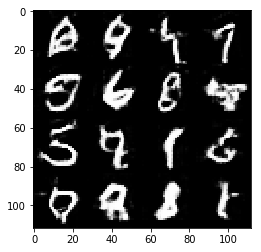

Epoch 2/2... Discriminator Loss: 1.2118... Generator Loss: 0.8640
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.8362
Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 0.7524
Epoch 2/2... Discriminator Loss: 1.2471... Generator Loss: 0.8523
Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 0.7400
Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 0.8865
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 0.6993
Epoch 2/2... Discriminator Loss: 1.2111... Generator Loss: 0.8082
Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.1970... Generator Loss: 0.5824


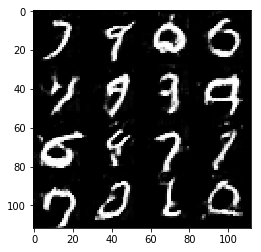

Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.4909
Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 0.6054
Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 0.7846
Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 0.9086
Epoch 2/2... Discriminator Loss: 1.3106... Generator Loss: 0.5895
Epoch 2/2... Discriminator Loss: 1.2352... Generator Loss: 0.6204
Epoch 2/2... Discriminator Loss: 1.2388... Generator Loss: 0.7640
Epoch 2/2... Discriminator Loss: 1.2080... Generator Loss: 0.7380
Epoch 2/2... Discriminator Loss: 1.2696... Generator Loss: 0.6017
Epoch 2/2... Discriminator Loss: 1.2709... Generator Loss: 0.7531


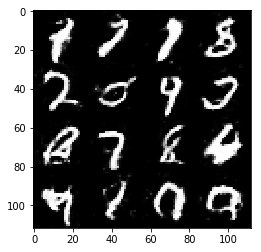

Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 0.7863
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 0.7317
Epoch 2/2... Discriminator Loss: 1.2662... Generator Loss: 0.9094
Epoch 2/2... Discriminator Loss: 1.1850... Generator Loss: 0.8024
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.6876
Epoch 2/2... Discriminator Loss: 1.2595... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.2342... Generator Loss: 0.7475
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 0.8986
Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 0.7385
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.5812


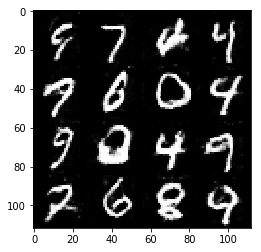

Epoch 2/2... Discriminator Loss: 1.2128... Generator Loss: 0.6622
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.7675
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.5345
Epoch 2/2... Discriminator Loss: 1.2721... Generator Loss: 0.7313
Epoch 2/2... Discriminator Loss: 1.2574... Generator Loss: 0.8695
Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 0.6598
Epoch 2/2... Discriminator Loss: 1.2355... Generator Loss: 0.8772
Epoch 2/2... Discriminator Loss: 1.2780... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 1.2631... Generator Loss: 0.6104


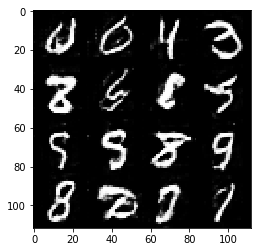

Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 0.6675
Epoch 2/2... Discriminator Loss: 1.1633... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 1.2609... Generator Loss: 0.7988
Epoch 2/2... Discriminator Loss: 1.2182... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 1.2404... Generator Loss: 0.6970


In [149]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6315... Generator Loss: 1.2495
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 1.6469
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 1.6633
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7255


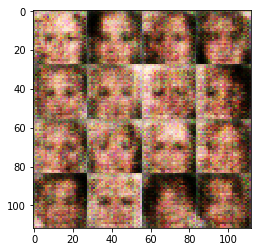

Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7467


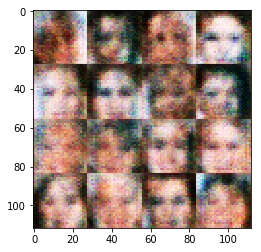

Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7736


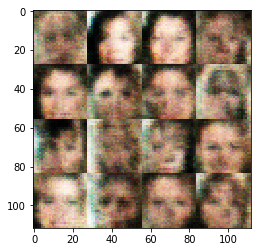

Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7021


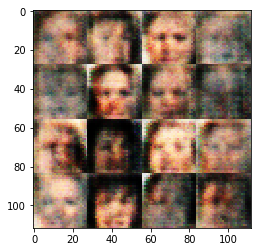

Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6592


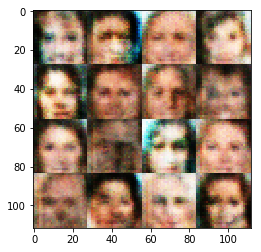

Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6866


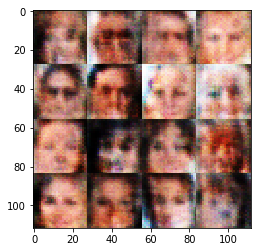

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.6947


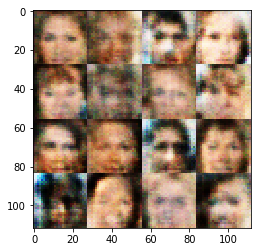

Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7032


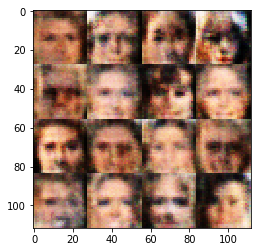

Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7075


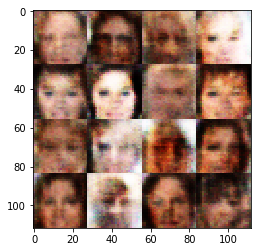

Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6938


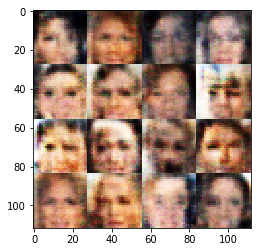

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.6823


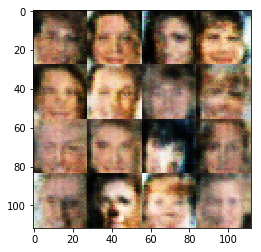

Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6620


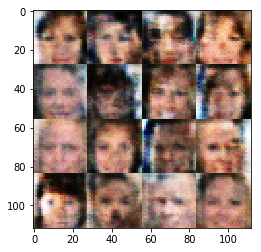

Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6278


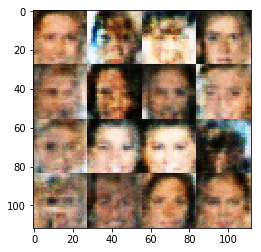

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6919


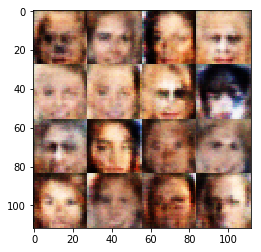

Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6716


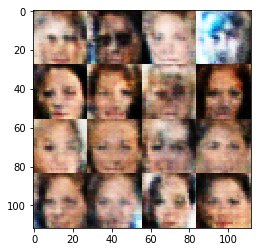

Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7336


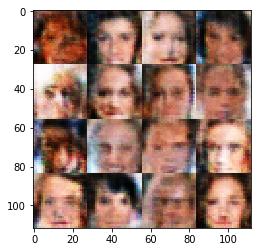

Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7082


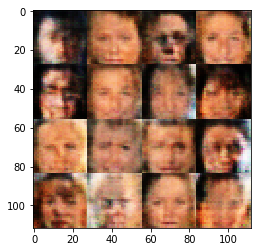

Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.6551


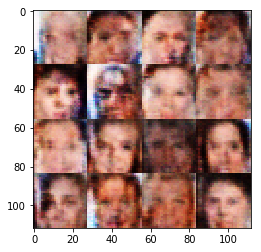

Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6670


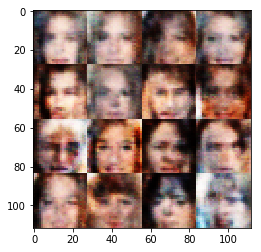

Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7058


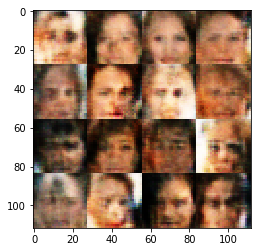

Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6857


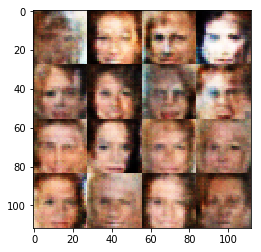

Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6290


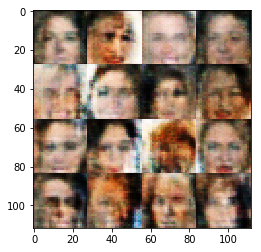

Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6565


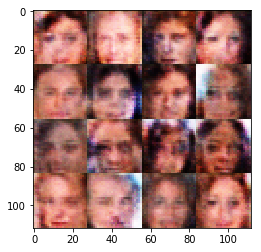

Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7091


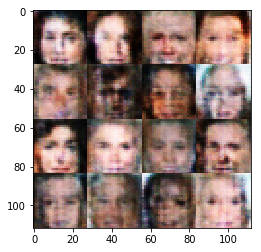

Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7043


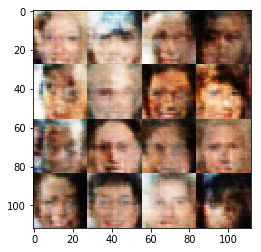

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.6716


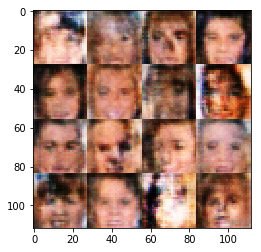

Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7106


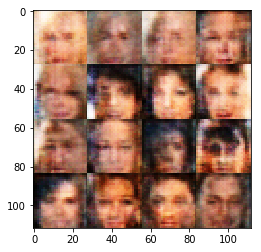

Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6435


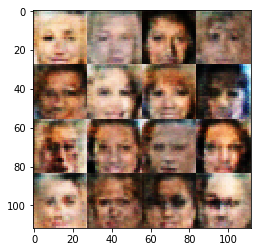

Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7082


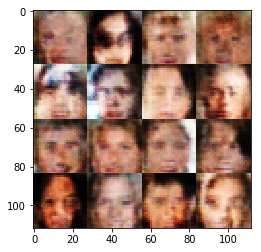

Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6820


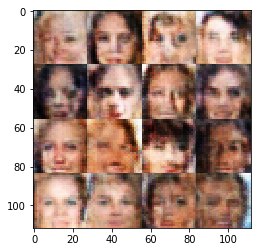

Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.6919


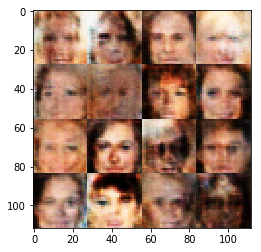

Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7064


In [150]:
batch_size =64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.